In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import seaborn as sb
import pennylane as qml
from pennylane import numpy as np
from pennylane import qaoa
import cmath
import matplotlib.pyplot as plt


In [3]:
import torch

In [4]:

def bitwise_input(input,n_max = 16):  
    bits = []
    for i in bin(input)[2:]:
        bits.append((int(i)*1.1)-0.1)
    # filling
    for _ in range(n_max - len(bits)):
        bits.append(0)
    return bits[:n_max]

print(bitwise_input(25112313))

[1.0, -0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -0.1, -0.1, 1.0, -0.1, 1.0, 1.0, 1.0]


In [170]:
qbits = 16
depth = 1

dev = qml.device("default.qubit", wires=qbits,shots = 2)

@qml.qnode(dev)
def qnode(inputs,weights):
    #print(weights)
    weights = weights.reshape(depth,qbits)
    qml.AngleEmbedding(bitwise_input(inputs,qbits),wires = range(qbits))
    qml.BasicEntanglerLayers(weights, wires=range(qbits))
    for i in range(depth):
        #qml.Snapshot()
        # Parameterised layer
        for y in range(qbits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(qbits - 1):
            qml.CZ(wires=[y, y + 1])
    #qml.Snapshot()
    output = []
    
    for i in range(qbits):   
        output.append(qml.expval(qml.PauliZ(i)))
    return output
#qml.sample(qml.PauliY(0))
# [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)] 
# qml.probs(wires=list(range(qbits)))

weight_shapes = {"weights": (depth, qbits)}
qlayer = qml.qnn.TorchLayer(qnode,weight_shapes)
model = torch.nn.Sequential(*[qlayer])
    

In [171]:
opt = torch.optim.SGD(model.parameters(), lr=0.2)

In [172]:
#!pip install seaborn freetype


In [173]:
testrange = 20
out = []
for i in range(testrange):
    inp = torch.tensor(12502)
    out.append(model(inp).numpy().tolist())
#out = model(inp).numpy().tolist()

In [174]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

0.weights tensor([[3.7942, 5.2994, 1.2478, 2.6690, 1.5884, 2.4169, 2.6447, 2.9191, 2.1032,
         0.5807, 4.8174, 5.1270, 5.6105, 1.4484, 5.7314, 4.2068]])


In [175]:
print(out)
#read = qml.snapshots(qlayer)(torch.tensor(25234))[0].numpy().real

[[-1, 0, -1, 0, 0, -1, -1, 0, 0, 1, 0, 0, -1, 0, 1, 0], [0, 0, 0, -1, 1, 1, -1, -1, -1, 1, 1, 1, 1, -1, 0, 1], [0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0], [0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, -1, -1, -1, 0, -1], [-1, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0], [0, -1, 1, 1, -1, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, -1], [0, 0, -1, 0, 0, 0, 0, 1, 1, 0, 1, -1, 0, 1, 0, -1], [-1, 0, 1, 0, 0, 1, 0, -1, 0, -1, -1, 0, 1, 0, 1, 0], [1, 1, 0, -1, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, 1, 0, -1, -1, 1, -1, -1, 0, 0, 1, 0], [-1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0], [0, -1, 0, 1, 0, -1, 1, -1, 1, 1, 0, 1, -1, -1, 0, 0], [-1, -1, 0, 1, -1, 0, 1, -1, 0, 0, -1, 0, -1, -1, -1, 1], [0, -1, 0, -1, -1, 0, 0, -1, 0, 0, 0, 0, -1, -1, 1, 0], [0, 0, -1, 0, 0, 0, 1, 0, 0, -1, 1, -1, 1, 1, 1, 1], [1, 0, 1, 1, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, -1], [1, -1, 0, 0, -1, 1, 0, 0, -1, 0, -1, 1, 0, 1, -1, -1], [0, -1, 0, -1, -1, 0, -1, 0, 0, 1, 1, -1, -1, -1, 0, 0], [0, -1, 0, 0, 0, 0

<Axes: >

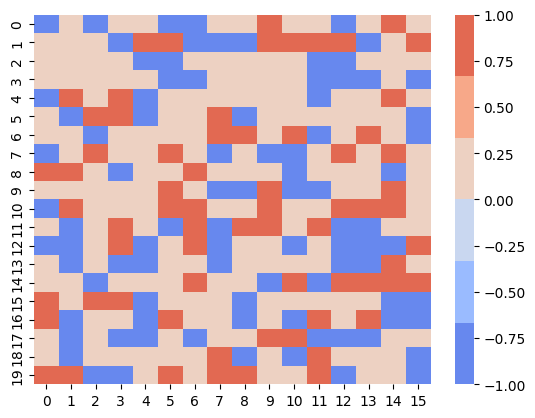

In [176]:
sb.heatmap(out,cmap= sb.color_palette("coolwarm"))

In [177]:
for i in range(len(out[0])):
    print(np.mean(out[:][i]))

-0.1875
0.125
-0.25
-0.375
0.0
-0.0625
0.0625
0.0
0.0
-0.0625
0.375
0.0
-0.3125
-0.3125
0.1875
-0.0625
